In [1]:
import os, gc, logging, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi, voronoi_plot_2d

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, OPTICS

import cudf

import tensorflow as tf
warnings.filterwarnings("ignore")

# Load Data

In [2]:
train = cudf.read_csv('../input/tabular-playground-series-feb-2022/train.csv').set_index("row_id")
test = cudf.read_csv('../input/tabular-playground-series-feb-2022/test.csv').set_index("row_id")

sample_submission = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

train = train.to_pandas()
test = test.to_pandas()

feature_cols = test.columns.tolist()

le = LabelEncoder()
train["target"] = le.fit_transform(train["target"])

for col in feature_cols:
    train[col] = train[col].astype("float32")
    test[col] = test[col].astype("float32")

In [3]:
train = train.drop_duplicates(keep='first', ignore_index=True)
df = train[feature_cols].append(test)
print(df.duplicated().sum() - test.duplicated().sum())

266


# AutoEncoder for Dimensionality Reduction

**AutoEncoder** is an **unsupervised Artificial Neural Network** that attempts to encode the data by compressing it into the lower dimensions (bottleneck layer or code) and then decoding the data to reconstruct the original input. The bottleneck layer (or code) holds the compressed representation of the input data [[1](https://www.analyticsvidhya.com/blog/2021/06/dimensionality-reduction-using-autoencoders-in-python/#:~:text=AutoEncoder%20is%20an%20unsupervised%20Artificial,to%20reconstruct%20the%20original%20input.&text=AutoEncoders%20usually%20consist%20of%20an%20encoder%20and%20a%20decoder.)]

![autoencoder](https://miro.medium.com/max/882/0*j9IZ2cJa2hS3TlOd.png)

[Image Source](https://medium.datadriveninvestor.com/dimensionality-reduction-using-an-autoencoder-in-python-bf540bb3f085)

In [4]:
n_components = 2

tf.random.set_seed(42)
KI = tf.keras.initializers.glorot_uniform(seed=42)

encoder_input = tf.keras.layers.Input(shape=(train[feature_cols].shape[1],), name="Input")
encoder_x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI, name="Encoder")(encoder_input)
encoder_output = tf.keras.layers.Dense(n_components, activation="swish", kernel_initializer=KI, name="Bottleneck")(encoder_x)

decoder_x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI, name="Decoder")(encoder_output)
decoder_output = tf.keras.layers.Dense(train[feature_cols].shape[1], kernel_initializer=KI, name="Output")(decoder_x)

encoder = tf.keras.Model(encoder_input, encoder_output)
autoencoder = tf.keras.Model(encoder_input, decoder_output)

autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(train[feature_cols], train[feature_cols], epochs=5)

Epoch 1/5
3875/3875 [==============================] - 9s 2ms/step - loss: 3.9460e-06
Epoch 2/5
3875/3875 [==============================] - 9s 2ms/step - loss: 3.4774e-06
Epoch 3/5
3875/3875 [==============================] - 8s 2ms/step - loss: 3.3827e-06
Epoch 4/5
3875/3875 [==============================] - 8s 2ms/step - loss: 3.3378e-06
Epoch 5/5
3875/3875 [==============================] - 8s 2ms/step - loss: 3.3081e-06


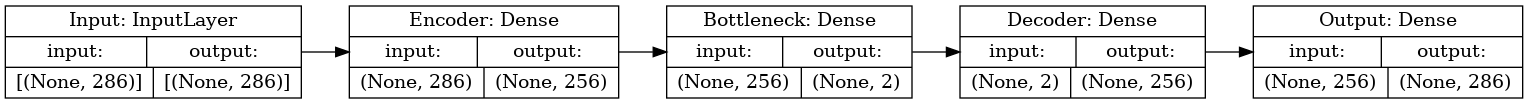

In [5]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, rankdir="LR")

In [6]:
enc_x = encoder.predict(train[feature_cols])
enc_t = encoder.predict(test[feature_cols])

enc_cols = []
for i in range(n_components):
    col = f"ENC{i+1}"
    train[col] = enc_x[:,i]
    train[col] = enc_x[:,i]
    test[col] = enc_t[:,i]
    test[col] = enc_t[:,i]
    enc_cols.append(col)

del autoencoder, encoder, history, enc_x, enc_t
gc.collect()

train[enc_cols].head()

ENC1      ENC2
0 -0.080976  0.061085
1  0.018284  0.027310
2  0.042021  0.026614
3  0.042931  0.033138
4 -0.078143 -0.022724

How our encoded data looks like

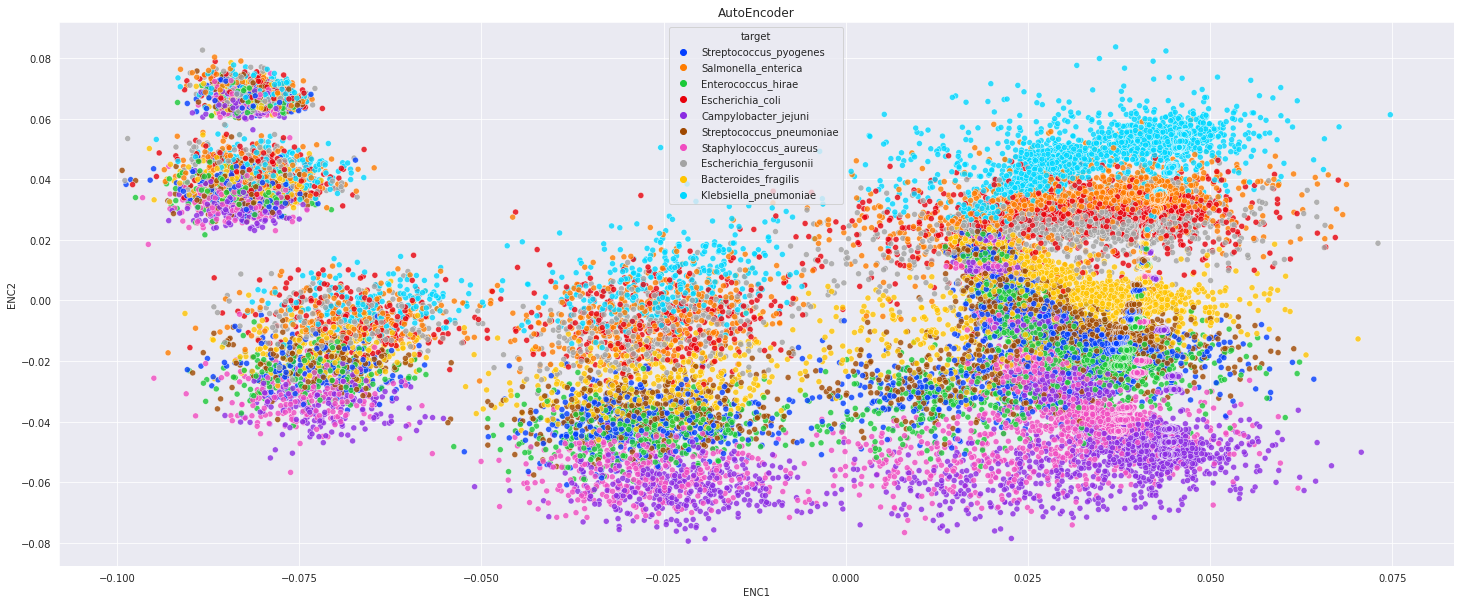

In [7]:
df_x = train[["ENC1", "ENC2", "target"]].copy()
df_x["target"] = le.inverse_transform(df_x["target"])
df_t = test[["ENC1", "ENC2"]].copy()

plt.figure(figsize=(25,10))
sns.scatterplot(data=df_x, x="ENC1", y="ENC2", hue="target", alpha=0.8, palette="bright")
plt.title("AutoEncoder")
plt.show()

Let's see each bacteria species separately.

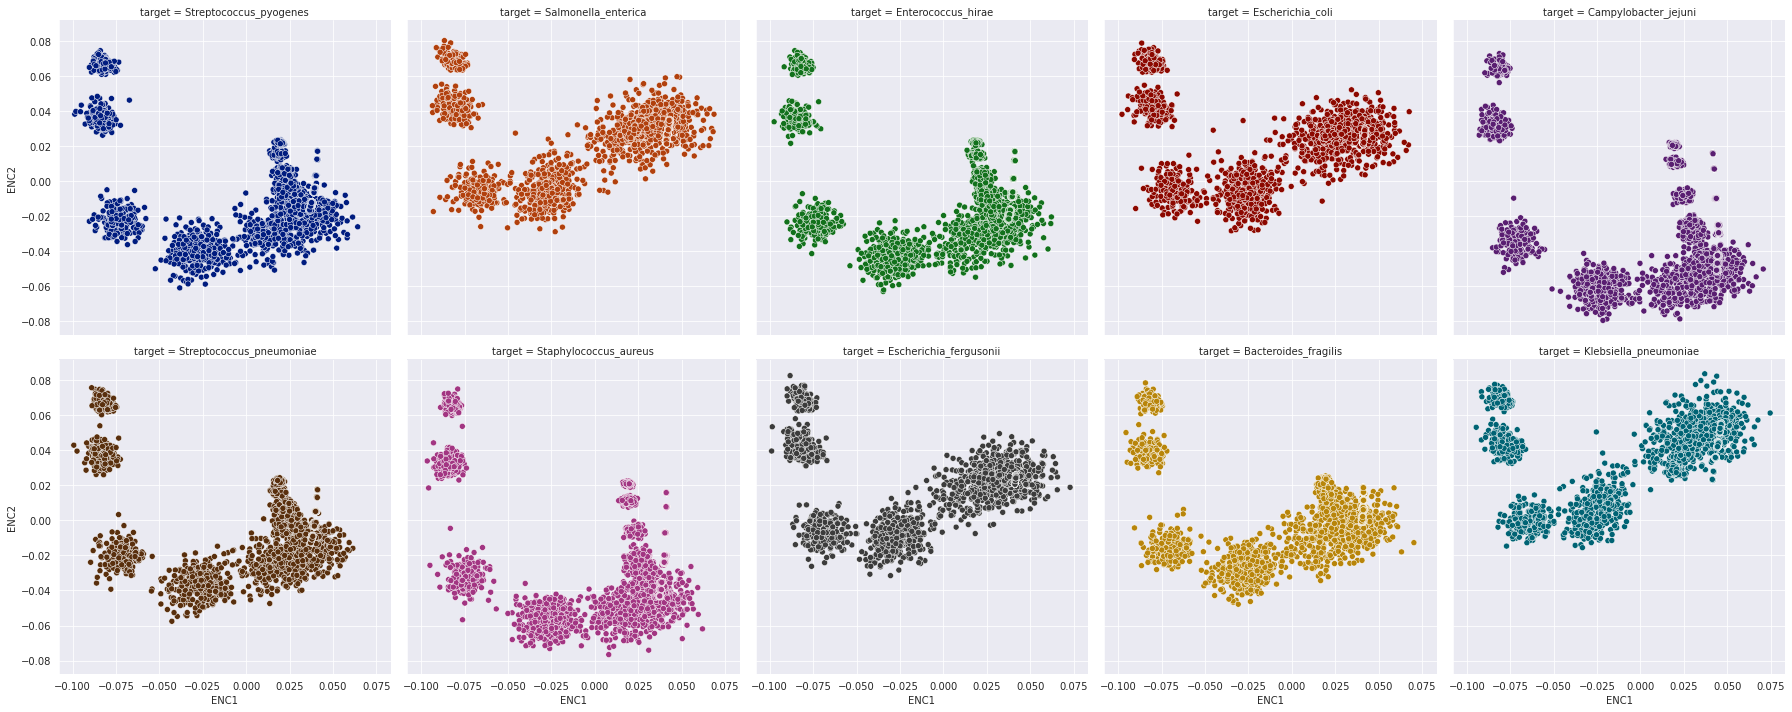

In [8]:
sns.relplot(data=df_x, 
            x="ENC1",
            y="ENC2",
            col="target", 
            hue="target",
            kind="scatter", 
            palette=sns.color_palette("dark"), 
            col_wrap=5,
            legend=False)
plt.show()

**As you can see from the two above plots, different bacteria species are stacked on each other and they are good separable, but there are two clusters at the left side, which all species present there** Probably those are the samples which have been made by noise. 

# Clustering

Let's cluster the encoded data to separate the aforementioned samples. 

[Here](https://scikit-learn.org/stable/modules/clustering.html) you can see the comparison between clustering algorithms and choose the one more appropriate for your problem. I wanted to go for `DBSCAN`, but it raises the allocated memory error (It's a well-known issue for DBSCAN implemented in scikit-learn). The closest algorithm to it is `OPTICS`, but it has another issue that is time-consuming. `KMeans` is not a good fit, since I want to cluster nearby points by their neighbours and not a centroid (clusters are not in a circle shape around a centroid), to separate far away samples. However, with proper parameters, KMeans can work too. 



## KMeans with No-Hint

In [9]:
gc.collect()
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000, n_init=100)

df_x["cluster"] = kmeans.fit_predict(train[enc_cols])
df_t["cluster"] = kmeans.predict(test[enc_cols])

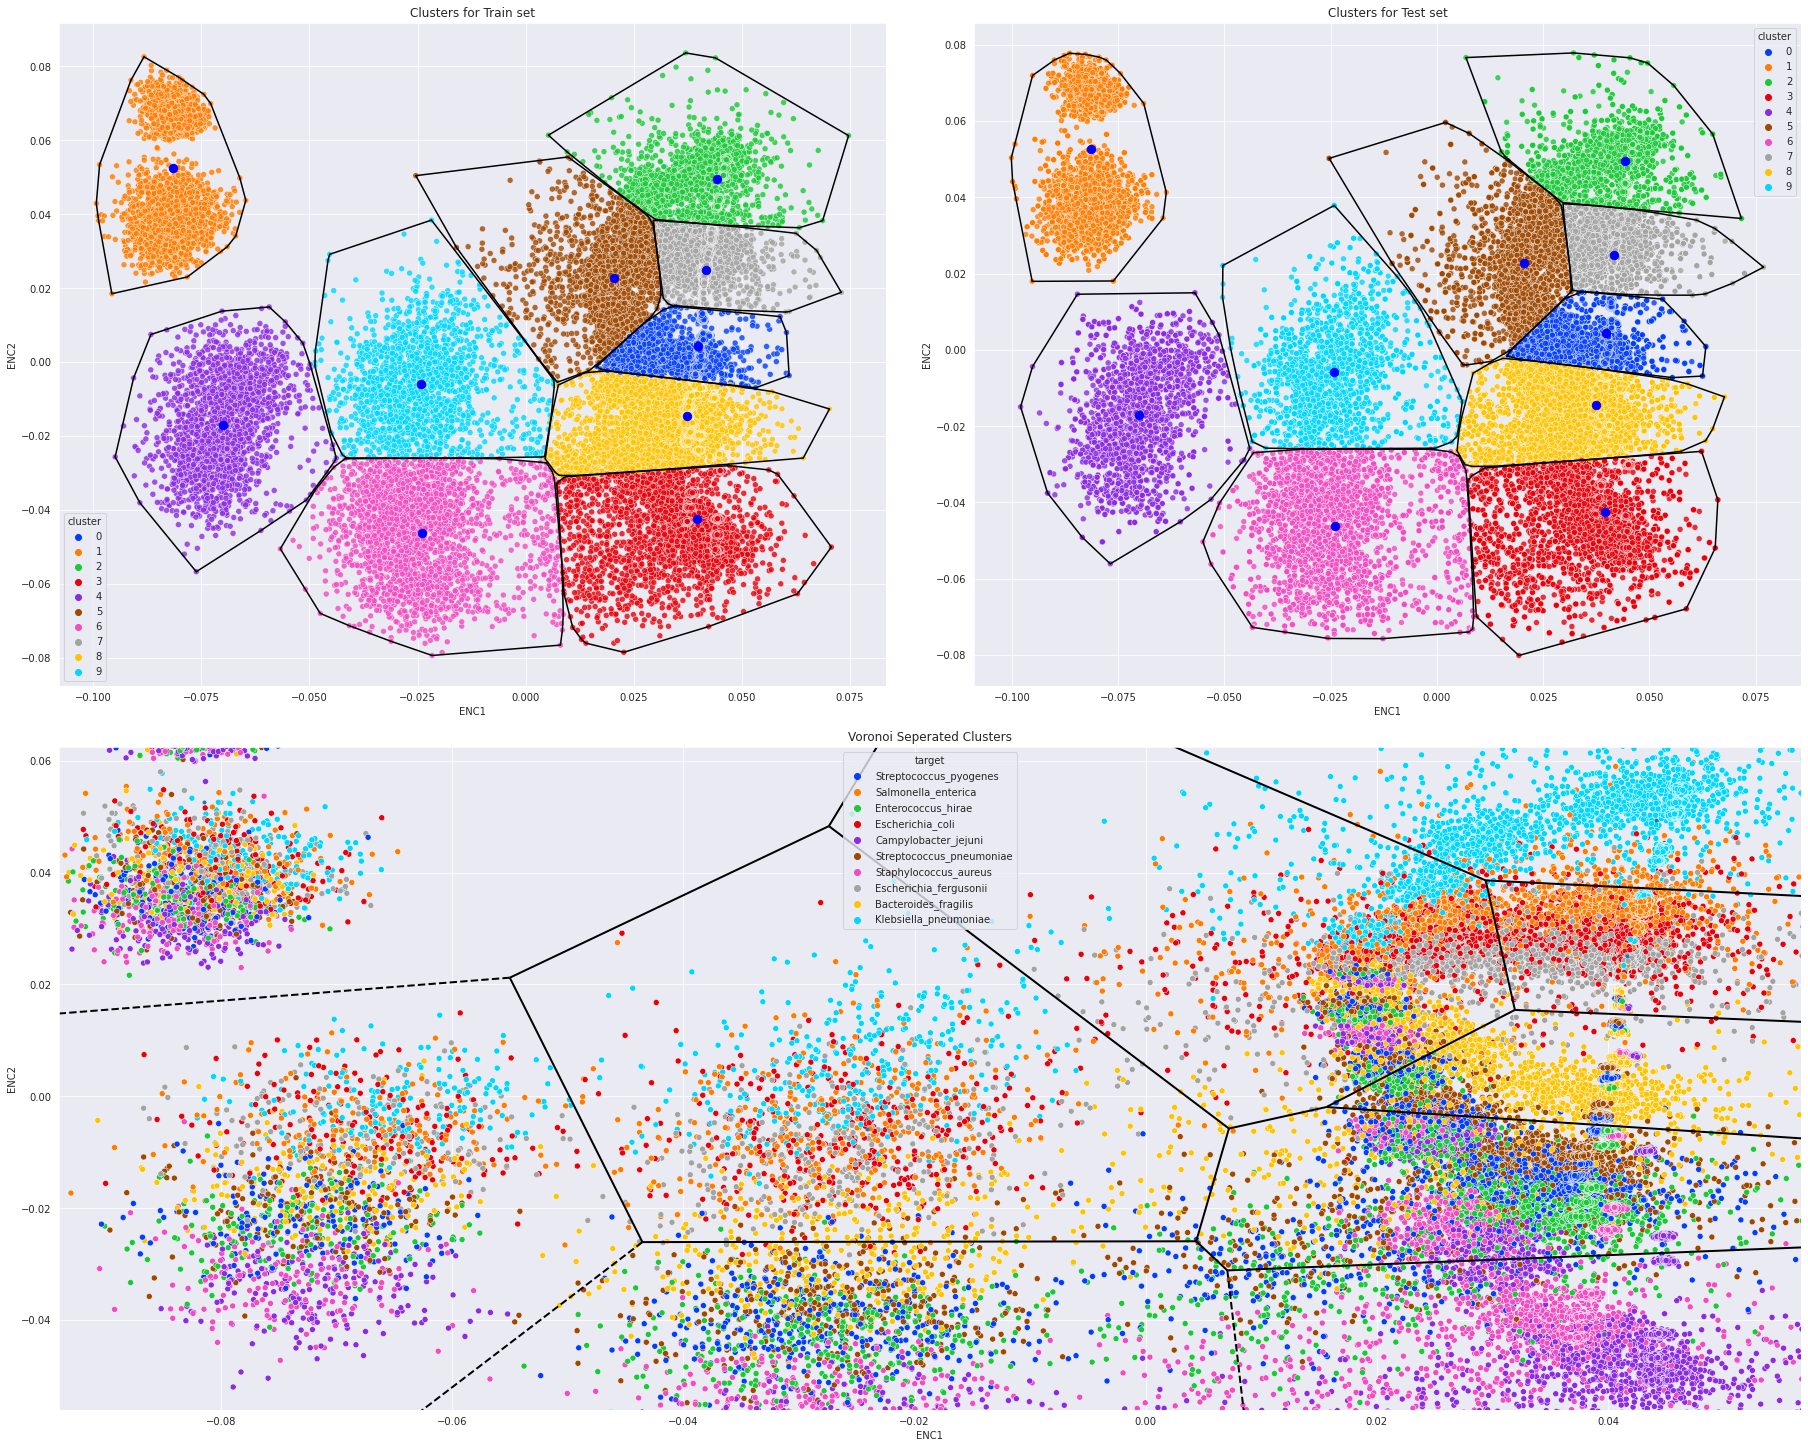

In [10]:
centroids_list = kmeans.cluster_centers_

mosaic = """
AB
CC
"""
fig = plt.figure(constrained_layout=True, figsize=(25,20))
ax_dict = fig.subplot_mosaic(mosaic)

sns.scatterplot(data=df_x, x="ENC1", y="ENC2", hue="cluster", alpha=0.8, palette="bright", ax=ax_dict["A"])
for c in range(n_clusters):
    cluster = df_x[df_x.cluster==c]
    hull = ConvexHull(cluster[enc_cols])
    points = cluster[enc_cols].values
    for simplex in hull.simplices:
        ax_dict["A"].plot(points[simplex, 0], points[simplex, 1], 'k-')
ax_dict["A"].scatter(centroids_list[:, 0], centroids_list[:, 1], s=70, c='b')
ax_dict["A"].set_title("Clusters for Train set")


sns.scatterplot(data=df_t, x="ENC1", y="ENC2", hue="cluster", alpha=0.8, palette="bright", ax=ax_dict["B"])
for c in range(n_clusters):
    cluster = df_t[df_t.cluster==c]
    hull = ConvexHull(cluster[enc_cols])
    points = cluster[enc_cols].values
    for simplex in hull.simplices:
        ax_dict["B"].plot(points[simplex, 0], points[simplex, 1], 'k-')
ax_dict["B"].scatter(centroids_list[:, 0], centroids_list[:, 1], s=70, c='b')
ax_dict["B"].set_title("Clusters for Test set")

vor = Voronoi(centroids_list)
voronoi_plot_2d(vor, ax=ax_dict["C"], show_vertices=False, line_width=2.)
sns.scatterplot(x=df_x["ENC1"], y=df_x["ENC2"], hue=df_x["target"], palette="bright", ax=ax_dict["C"])
ax_dict["C"].set_title("Voronoi Seperated Clusters")
plt.show()

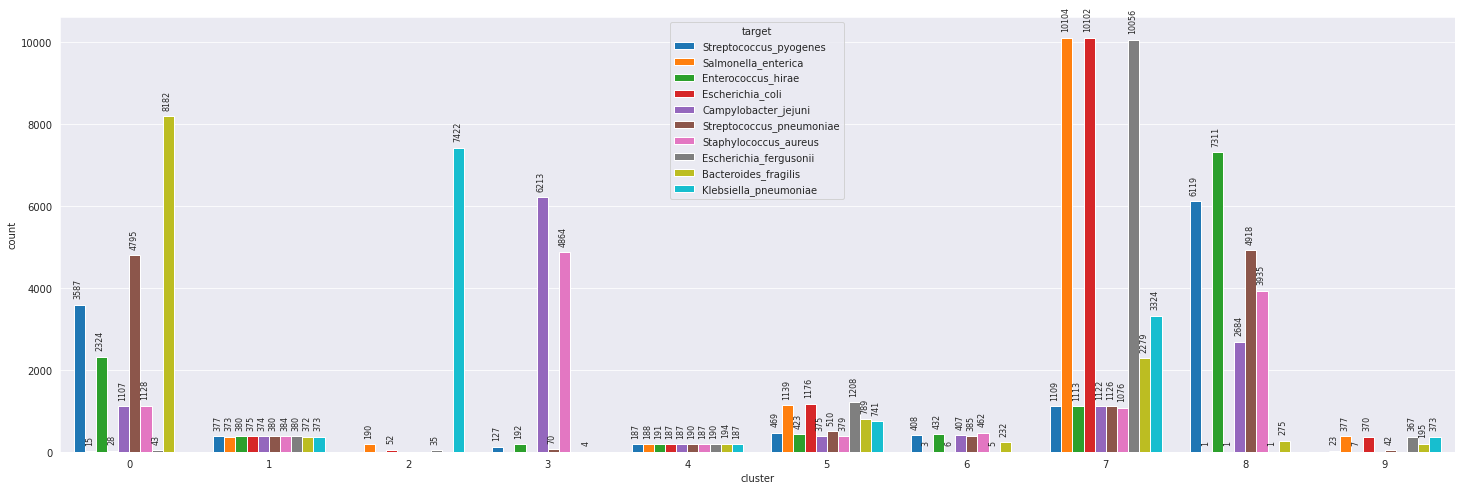

In [11]:
plt.figure(figsize=(25,8))
ax = sns.countplot(data=df_x, x="cluster", hue="target", saturation=1)
for p in ax.patches:
        ax.annotate('{:g}'.format(p.get_height()), (p.get_x(), p.get_height()+200), rotation=90, fontsize=8)
plt.show()

We could separate the far away samples with clustering. 2 clusters have almost the equal number of each species in it. 

But what about clustering to spearate bacteria species? I want to run clustering with a target hint, and then fixing the cluster centroids to see what happens!

## KMeans with Target Hint

First I run KMeans on the features plus target column. After that I would run clustering by the centroids initilization from pretrained clustering. I also include all features (not just the encoded columns as above). 

In [12]:
 class KMeansFeaturizer:

    def __init__(self, n_clusters=10, max_iter=1000, n_init=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init
        self.random_state = random_state
        # I whould scale target columns, to make target column farther from each other, to help better separation
        # because kmeans uses euclidean distance between points
        self.target_scale = 20.0
        
    def fit(self, X, y=None):
        
        if y is None:
            km_model = KMeans(n_clusters=self.n_clusters, n_init=self.n_init, max_iter=self.max_iter, random_state=self.random_state)
            km_model.fit(X)
            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self
        

        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))
        km_model_pretrain = KMeans(n_clusters=self.n_clusters, n_init=self.n_init, 
                                   max_iter=self.max_iter, random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)
        
        km_model = KMeans(n_clusters=self.n_clusters, init=km_model_pretrain.cluster_centers_[:,:-1], 
                          n_init=1, max_iter=1)
        km_model.fit(X)
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
    
    def predict(self, X, y=None):
        clusters = self.km_model.predict(X)
        return clusters[:,np.newaxis]
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X, y)

In [13]:
gc.collect()
n_clusters = 10
kmeans_hint = KMeansFeaturizer(n_clusters=n_clusters)

df_x["cluster"] = kmeans_hint.fit_predict(train[feature_cols], train["target"])
df_t["cluster"] = kmeans_hint.predict(test[feature_cols])

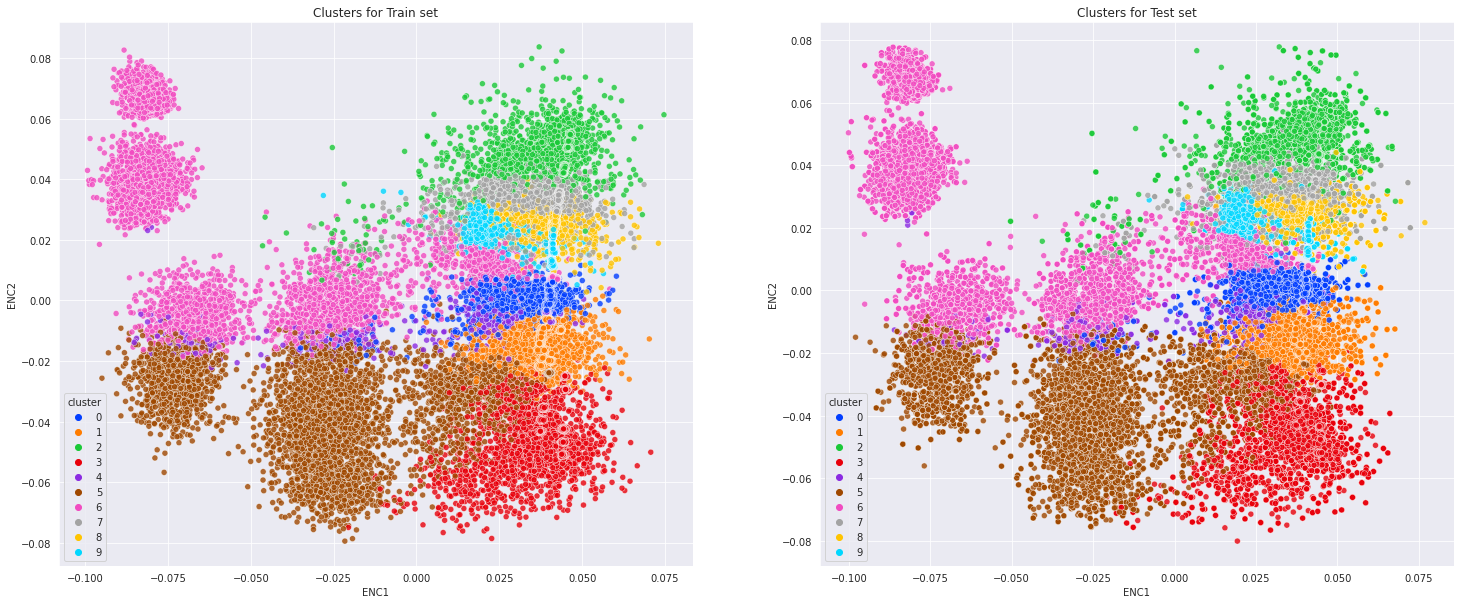

In [14]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
sns.scatterplot(data=df_x, x="ENC1", y="ENC2", hue="cluster", alpha=0.8, palette="bright")
plt.title("Clusters for Train set")

plt.subplot(1,2,2)
sns.scatterplot(data=df_t, x="ENC1", y="ENC2", hue="cluster", alpha=0.8, palette="bright")
plt.title("Clusters for Test set")

plt.show()

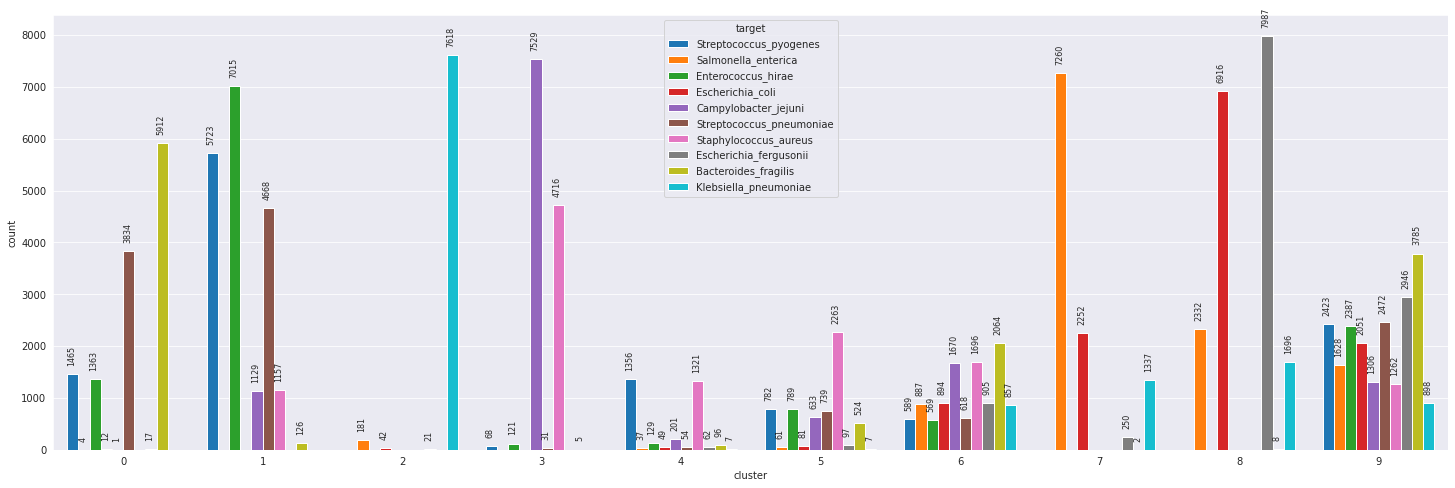

In [15]:
plt.figure(figsize=(25,8))
ax = sns.countplot(data=df_x, x="cluster", hue="target", saturation=1)
for p in ax.patches:
        ax.annotate('{:g}'.format(p.get_height()), (p.get_x(), p.get_height()+200), rotation=90, fontsize=8)
plt.show()

We can see that the centroids are stacked on each other as the different targets are. But since K-Means clusters are sphere, and the radius is the maximum error of representing points, the shape of each cluster is not like what we saw for bacteria species. 

In [16]:
cluster_cols = [f"cluster_{i}" for i in range(n_clusters)]
train = pd.concat([train, pd.get_dummies(df_x, prefix="cluster", columns=["cluster"])[cluster_cols]], axis=1)
test = pd.concat([test, pd.get_dummies(df_t, prefix="cluster", columns=["cluster"])[cluster_cols]], axis=1)

# PCA | LDA | SVD

In [17]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(train[feature_cols])
T_pca = pca.transform(test[feature_cols])

pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=pca_cols, index=train.index)
T_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, T_pca], axis=1)

del pca, X_pca, T_pca

train[pca_cols].head()

PC1       PC2
0  0.005596  0.074021
1 -0.022540  0.009497
2 -0.025577 -0.003203
3 -0.029190 -0.004093
4  0.040603  0.061478

In [18]:
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
X_lda = lda.fit_transform(train[feature_cols], train["target"])
T_lda = lda.transform(test[feature_cols])

lda_cols = [f"LDA{i+1}" for i in range(X_lda.shape[1])]

X_lda = pd.DataFrame(X_lda, columns=lda_cols, index=train.index)
T_lda = pd.DataFrame(T_lda, columns=lda_cols, index=test.index)

train = pd.concat([train, X_lda], axis=1)
test = pd.concat([test, T_lda], axis=1)

del lda, X_lda, T_lda
gc.collect()

train[lda_cols].head()

LDA1      LDA2
0 -0.239102 -0.275920
1  1.101657  0.154099
2  1.563511 -0.294791
3  2.864556 -0.154233
4 -1.319242 -0.011817

In [19]:
svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42)

X_svd = svd.fit_transform(train[feature_cols])
T_svd = svd.transform(test[feature_cols])

svd_cols = [f"SVD{i+1}" for i in range(X_svd.shape[1])]

X_svd = pd.DataFrame(X_svd, columns=svd_cols, index=train.index)
T_svd = pd.DataFrame(T_svd, columns=svd_cols, index=test.index)

train = pd.concat([train, X_svd], axis=1)
test = pd.concat([test, T_svd], axis=1)

del svd, X_svd, T_svd, 
gc.collect()

train[svd_cols].head()

SVD1      SVD2
0  0.033131  0.074604
1  0.002214  0.012410
2 -0.001658  0.000001
3 -0.003525 -0.000067
4  0.066942  0.059859

# Compare Results

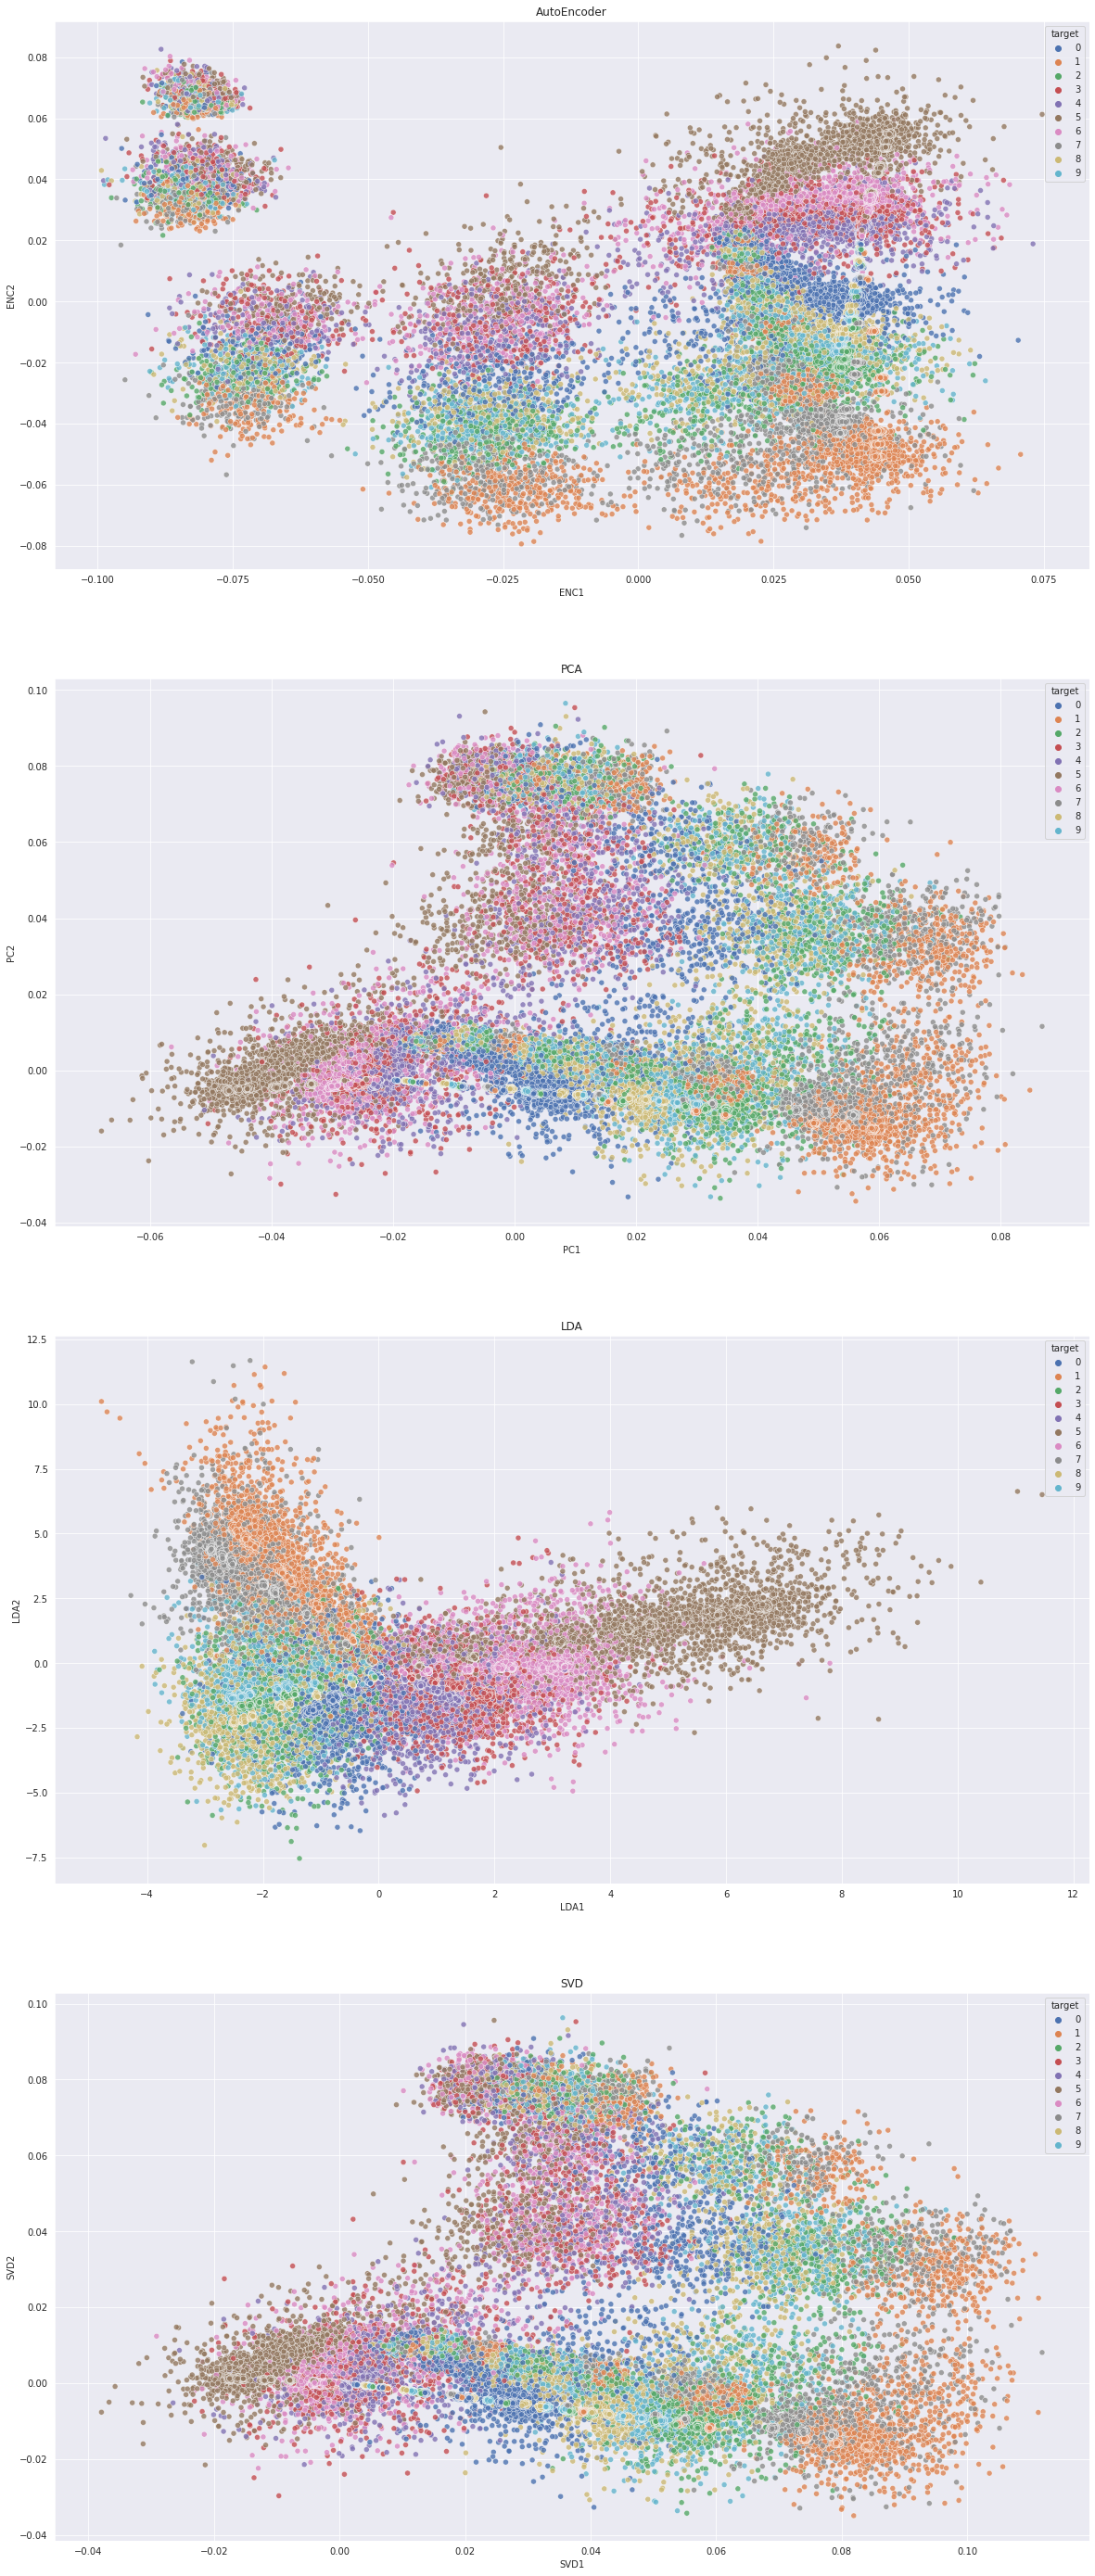

In [20]:
plt.figure(figsize=(20,50))
plt.subplot(4,1,1)
sns.scatterplot(data=train, x="ENC1", y="ENC2", hue="target", alpha=0.8, palette="deep")
plt.title("AutoEncoder")

plt.subplot(4,1,2)
sns.scatterplot(data=train, x="PC1", y="PC2", hue="target", alpha=0.8, palette="deep")
plt.title("PCA")

plt.subplot(4,1,3)
sns.scatterplot(data=train, x="LDA1", y="LDA2", hue="target", alpha=0.8, palette="deep")
plt.title("LDA")

plt.subplot(4,1,4)
sns.scatterplot(data=train, x="SVD1", y="SVD2", hue="target", alpha=0.8, palette="deep")
plt.title("SVD")

plt.show()

In [21]:
feature_cols += enc_cols
feature_cols += pca_cols
feature_cols += svd_cols
feature_cols += cluster_cols

# Train Neural Network

In [22]:
gc.collect()

x_train, x_valid, y_train, y_valid = train_test_split(train[feature_cols], train["target"], test_size=0.2, random_state=42, stratify=train["target"])   

KI = tf.keras.initializers.glorot_uniform(seed=1989)

input_nn = tf.keras.layers.Input(shape=(train[feature_cols].shape[1],))
x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=KI)(input_nn)
x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI)(x)
x = tf.keras.layers.Dense(512, activation="relu", kernel_initializer=KI)(x)
x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI)(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=KI)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_nn = tf.keras.layers.Dense(10, activation="softmax", kernel_initializer=KI)(x)

model = tf.keras.Model(input_nn, output_nn)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 302)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               38784     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0   

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, mode="min", restore_best_weights=True, verbose=1)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, mode="min", min_lr=1e-5, verbose=1)

history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_valid, y_valid), 
                    epochs=50, 
                    callbacks=[cb_lr, cb_es])

Epoch 1/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.6961 - accuracy: 0.7264 - val_loss: 0.3038 - val_accuracy: 0.8910
Epoch 2/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.2886 - accuracy: 0.8949 - val_loss: 0.2231 - val_accuracy: 0.9183
Epoch 3/50
3100/3100 [==============================] - 8s 3ms/step - loss: 0.2429 - accuracy: 0.9093 - val_loss: 0.2193 - val_accuracy: 0.9117
Epoch 4/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.2185 - accuracy: 0.9168 - val_loss: 0.1980 - val_accuracy: 0.9223
Epoch 5/50
3100/3100 [==============================] - 8s 3ms/step - loss: 0.2043 - accuracy: 0.9205 - val_loss: 0.2113 - val_accuracy: 0.9192
Epoch 6/50
3100/3100 [==============================] - 9s 3ms/step - loss: 0.1927 - accuracy: 0.9248 - val_loss: 0.2887 - val_accuracy: 0.8987

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
3100/3100 [==============================] -

# Submission

In [24]:
preds_test = np.argmax(model.predict(test[feature_cols]),axis=1)
preds_test = le.inverse_transform(preds_test)

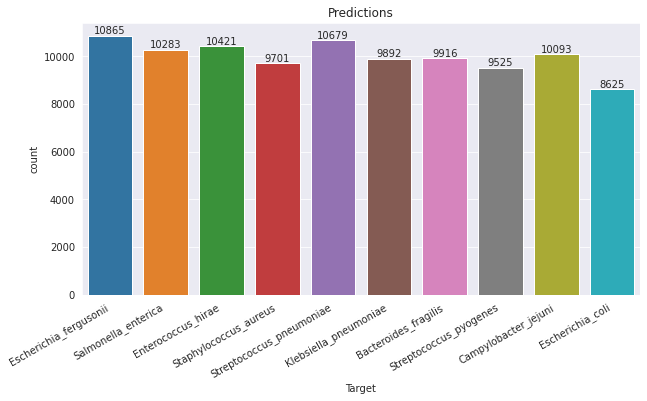

In [25]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x=preds_test)
plt.title("Predictions")
plt.xlabel("Target")
plt.xticks(rotation=30, ha='right')
ax.bar_label(ax.containers[0])
plt.show()

In [26]:
sample_submission['target'] = preds_test
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

row_id                  target
0  200000  Escherichia_fergusonii
1  200001     Salmonella_enterica
2  200002      Enterococcus_hirae
3  200003     Salmonella_enterica
4  200004   Staphylococcus_aureus